<a href="https://colab.research.google.com/github/bluepeach1121/CNN_Model_MNIST/blob/main/Mal_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Malaria is a life-threatening disease caused by Plasmodium parasites, which are transmitted to humans through the bites of infected Anopheles mosquitoes. The disease is prevalent in sub-Saharan Africa, Asia, and Latin America. Symptoms typically include fever, chills, headache, nausea, and muscle pain, which can escalate to severe complications like anemia, cerebral malaria, and multi-organ failure if left untreated.

I hate malaria cuz I had it quite a few time in highschool and I was always an awful experience..

In [48]:
import torch
from torch import nn

In [49]:
#device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#1. get data....

In [50]:
import requests
import zipfile
from pathlib import Path as path

# Setup path to the dataset folder
dataset_path = path('Data/')
image_path = dataset_path / 'Dataset'

# If the dataset folder doesn't exist, download and prepare it....
if dataset_path.is_dir():
    print(f'{dataset_path} directory already exists... skipping download')
else:
    print(f'{dataset_path} doesnt exist, creating one....')
    dataset_path.mkdir(parents=True, exist_ok=True)

    # Download Malaria dataset
    with open(dataset_path / 'Malaria_Dataset.zip', 'wb') as f:
        request = requests.get('https://github.com/krishnaik06/Malaria-Detection/raw/master/Dataset.zip')
        print('Downloading Malaria dataset...')
        f.write(request.content)

    # Unzip Malaria dataset
    with zipfile.ZipFile(dataset_path / 'Malaria_Dataset.zip', 'r') as zip_ref:
        print('Unzipping Malaria dataset...')
        zip_ref.extractall(dataset_path)

print('Done.')


Data directory already exists... skipping download
Done.


In [51]:
import os
def walk_through_dir(dir_path):
    """ walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')


In [52]:
walk_through_dir(image_path)

there are 2 directories and 0 images in Data/Dataset
there are 2 directories and 0 images in Data/Dataset/Train
there are 0 directories and 220 images in Data/Dataset/Train/Parasite
there are 0 directories and 196 images in Data/Dataset/Train/Uninfected
there are 2 directories and 0 images in Data/Dataset/Test
there are 0 directories and 91 images in Data/Dataset/Test/Parasite
there are 0 directories and 43 images in Data/Dataset/Test/Uninfected


In [53]:
# setup train and testing paths
train_dir = image_path / 'Train'
test_dir = image_path / 'Test'

train_dir, test_dir

(PosixPath('Data/Dataset/Train'), PosixPath('Data/Dataset/Test'))

random image path is: Data/Dataset/Train/Parasite/C189P150ThinF_IMG_20151203_142224_cell_86.png
image class: Parasite
image size: (139, 139), width is 139, height is 139


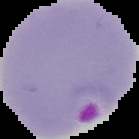

In [54]:
import random
from PIL import Image

# set seed
#random.seed(42)

#1. get all the image  paths
image_path_list = list(image_path.glob('*/*/*.png'))

#2. pick a random image path
random_image_path = random.choice(image_path_list)

#3. get image class from the path name (the image class is the name of the directory where the image is stored.)
image_class = random_image_path.parent.stem

#4. open image
img = Image.open(random_image_path)

#5. print metadata
print(f'random image path is: {random_image_path}')
print(f'image class: {image_class}')
print(f'image size: {img.size}, width is {img.size[0]}, height is {img.size[1]}')
img


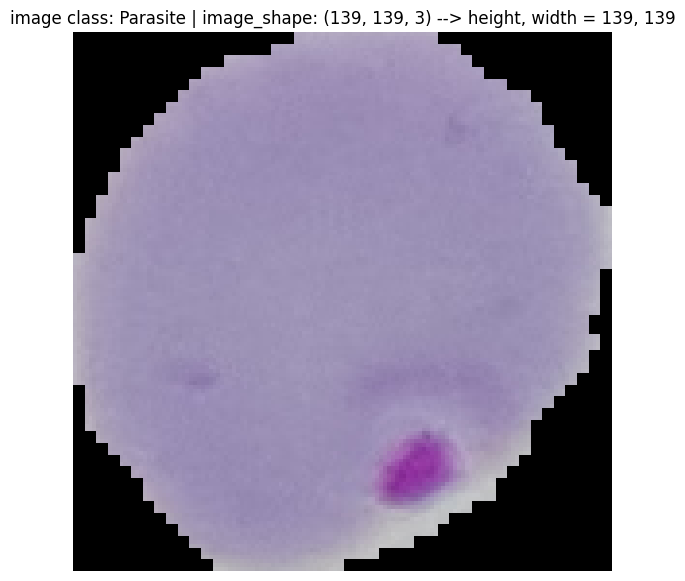

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into an array
img_as_array = np.asarray(img)

#plot the image with matplotlib
plt.figure(figsize=(7, 7))
plt.imshow(img_as_array)
plt.title(f'image class: {image_class} | image_shape: {img_as_array.shape} --> height, width = {img.size[1]}, {img.size[0]}')
plt.axis('off');

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
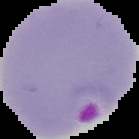

In [56]:
img_as_array

#2. transforming data.
1. turn your data into tensors.
2. turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset` and `Dataloader`.

In [57]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [58]:
data_transform = transforms.Compose([
    #resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # turn the image into a torch tensor
    transforms.ToTensor()
])

In [59]:
data_transform(img).shape

torch.Size([3, 64, 64])

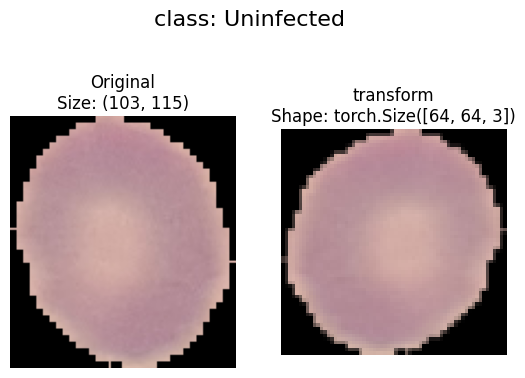

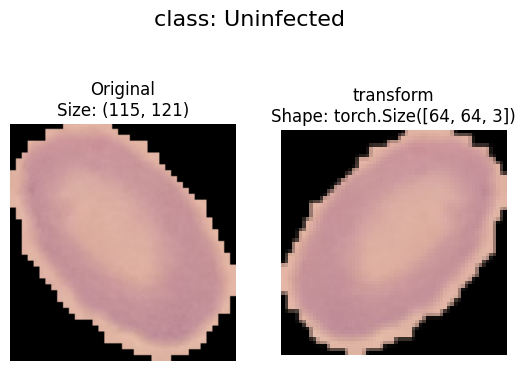

In [60]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    selects random images from a path of images and loads/transforms them then
    plots the original vs the transformed version
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis('off')

            #transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'transform\nShape: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=2,
                        seed=None)

# loading image using dataloader

In [61]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None) #transform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 416
     Root location: Data/Dataset/Train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 134
     Root location: Data/Dataset/Test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [62]:
class_names = train_data.classes
class_names

['Parasite', 'Uninfected']

In [63]:
class_dict = train_data.class_to_idx
class_dict

{'Parasite': 0, 'Uninfected': 1}

In [64]:
len(train_data), len(test_data)

(416, 134)

In [65]:
# index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'image tensor: \n {img}')
print(f'image shape: {img.shape}')
print(f'image label: {label}')
print(f'image datatype: {img.dtype}')
print(f'label datatype: {type(label)}')

image tensor: 
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
image shape: torch.Size([3, 64, 64])
image label: 0
image datatype: torch.float32
label datatype: <class 'int'>


original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'Parasite')

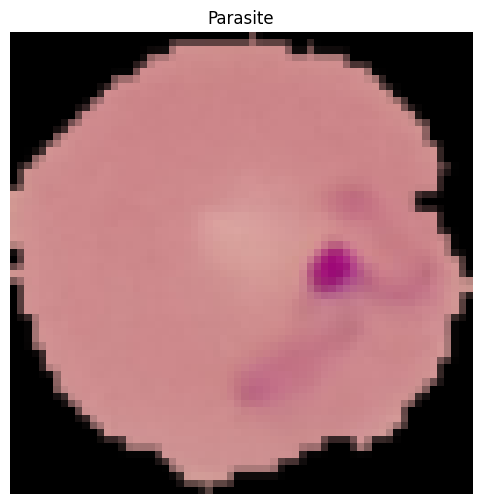

In [66]:
#rearrange dimension order
img_permute = img.permute(1, 2, 0)

#print out different shapes
print(f'original shape: {img.shape} -> [color_channels, height, width]')
print(f'image permute: {img_permute.shape} -> [height, width, color_channels]')

#plot the image
plt.figure(figsize=(12, 6))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label])

# turning loaded data into `dataloader`

In [67]:
import os
os.cpu_count()

2

In [68]:
# turn train and test datasets into dataloader's
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size= BATCH_SIZE,
                              shuffle= True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=os.cpu_count())

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79e50978a2f0>,
 <torch.utils.data.dataloader.DataLoader at 0x79e5081a3910>)

In [69]:
len(train_dataloader), len(test_dataloader)

(13, 5)

In [70]:
img, label =next(iter(train_dataloader))

print(f'image shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'label shape: {label.shape}')

image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
label shape: torch.Size([32])


In [71]:
# create a transform
from torchvision import transforms
train_transforms =transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [72]:
from typing import Tuple, Dict, List
import pathlib

#create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    #2. adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f'for display purposes, n shouldnt be larger than 10')

    #3. set the seed
    if seed:
        random.seed(seed)

    #4. get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    #5. setup plot
    plt.figure(figsize=(16, 8))


    #6. loop through indexes and plot them with plot them with matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        #7. adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

        #plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f'classes: {classes[targ_label]}'
            if display_shape:
                title = title + f'\nshape: {targ_image_adjust.shape}'
        plt.title(title)


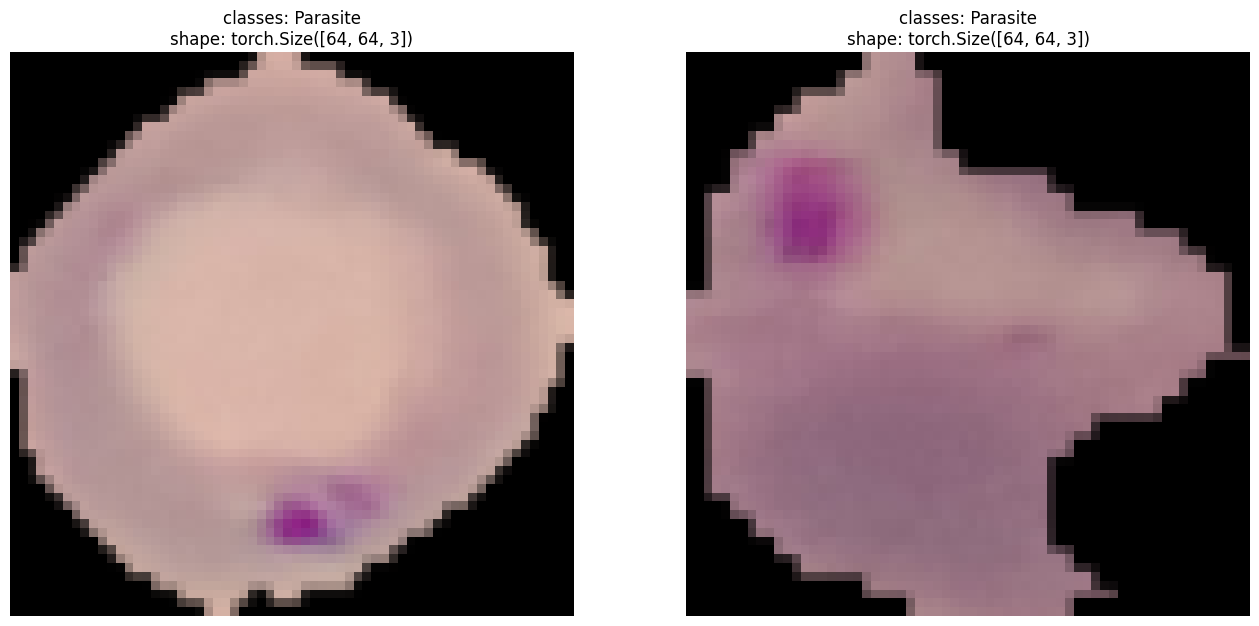

In [73]:
#display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=2,
                      classes=class_names,
                      seed=None)

In [74]:
#get all the image path.
image_path_list = list(image_path.glob('*/*/*.png'))
image_path_list[:10]

[PosixPath('Data/Dataset/Train/Parasite/C189P150ThinF_IMG_20151203_142224_cell_81.png'),
 PosixPath('Data/Dataset/Train/Parasite/C33P1thinF_IMG_20150619_114756a_cell_181.png'),
 PosixPath('Data/Dataset/Train/Parasite/C39P4thinF_original_IMG_20150622_105102_cell_91.png'),
 PosixPath('Data/Dataset/Train/Parasite/C38P3thinF_original_IMG_20150621_112116_cell_204.png'),
 PosixPath('Data/Dataset/Train/Parasite/C37BP2_thinF_IMG_20150620_131423a_cell_92.png'),
 PosixPath('Data/Dataset/Train/Parasite/C39P4thinF_original_IMG_20150622_105102_cell_88.png'),
 PosixPath('Data/Dataset/Train/Parasite/C33P1thinF_IMG_20150619_115808a_cell_205.png'),
 PosixPath('Data/Dataset/Train/Parasite/C134P95ThinF_IMG_20151005_122552_cell_122.png'),
 PosixPath('Data/Dataset/Train/Parasite/C37BP2_thinF_IMG_20150620_132847a_cell_77.png'),
 PosixPath('Data/Dataset/Train/Parasite/C189P150ThinF_IMG_20151203_142113_cell_86.png')]

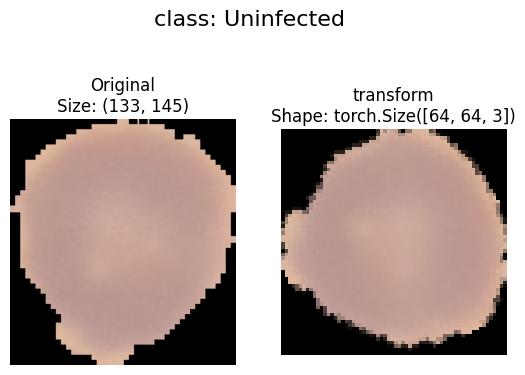

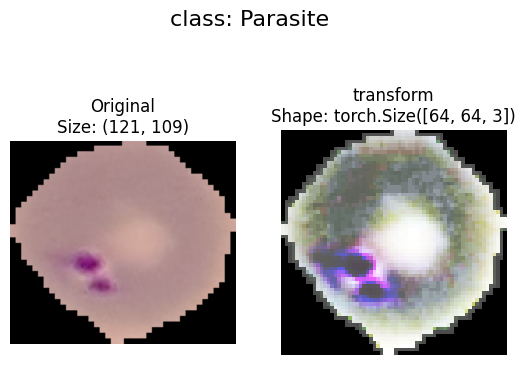

In [75]:
# plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=2,
    seed=None
)

# creating my CNN

In [76]:
class CNN_1(nn.Module):
    """
    inspired by the TinyVGG model
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:

        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                    out_channels = hidden_units,
                    kernel_size = 3,
                    stride = 1,
                    padding = 1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels= hidden_units,
                    out_channels= hidden_units,
                    kernel_size=3,
                    stride= 1,
                    padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2,
                        padding=1) # default stride values is same as kernel size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                    out_channels = hidden_units,
                    kernel_size = 3,
                    stride = 1,
                    padding = 1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels= hidden_units,
                    out_channels= hidden_units,
                    kernel_size=3,
                    stride= 1,
                    padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2,
                        padding=1) # default stride values is same as kernel size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units * 289,
                    out_features=output_shape)
        )

    def forward(self, x):
        #print(x.shape) # commented out after testing
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

In [77]:
len(class_names)

2

In [78]:
torch.manual_seed(42)
model_0 = CNN_1(input_shape=3, # number of color channels in our image data
                  hidden_units=12, #
                  output_shape=len(class_names)).to(device)
model_0

CNN_1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3468, out_features=2, bias=True)
  )
)

In [79]:
#get a single image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [80]:
#try a forward pass
model_0(image_batch.to(device))

tensor([[ 0.0462, -0.0240],
        [ 0.0566, -0.0317],
        [ 0.0559, -0.0316],
        [ 0.0547, -0.0243],
        [ 0.0570, -0.0325],
        [ 0.0518, -0.0334],
        [ 0.0537, -0.0311],
        [ 0.0558, -0.0255],
        [ 0.0551, -0.0264],
        [ 0.0498, -0.0272],
        [ 0.0561, -0.0302],
        [ 0.0575, -0.0289],
        [ 0.0567, -0.0307],
        [ 0.0516, -0.0289],
        [ 0.0552, -0.0218],
        [ 0.0544, -0.0331],
        [ 0.0573, -0.0272],
        [ 0.0533, -0.0279],
        [ 0.0533, -0.0259],
        [ 0.0562, -0.0303],
        [ 0.0556, -0.0309],
        [ 0.0504, -0.0265],
        [ 0.0554, -0.0293],
        [ 0.0469, -0.0303],
        [ 0.0561, -0.0313],
        [ 0.0505, -0.0299],
        [ 0.0578, -0.0319],
        [ 0.0545, -0.0331],
        [ 0.0537, -0.0298],
        [ 0.0507, -0.0307],
        [ 0.0516, -0.0295],
        [ 0.0536, -0.0292]], grad_fn=<AddmmBackward0>)

In [81]:
# install torchinfo, import if it's available
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
CNN_1                                    [32, 2]                   --
├─Sequential: 1-1                        [32, 12, 33, 33]          --
│    └─Conv2d: 2-1                       [32, 12, 64, 64]          336
│    └─LeakyReLU: 2-2                    [32, 12, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 12, 64, 64]          1,308
│    └─LeakyReLU: 2-4                    [32, 12, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 12, 33, 33]          --
├─Sequential: 1-2                        [32, 12, 17, 17]          --
│    └─Conv2d: 2-6                       [32, 12, 33, 33]          1,308
│    └─LeakyReLU: 2-7                    [32, 12, 33, 33]          --
│    └─Conv2d: 2-8                       [32, 12, 33, 33]          1,308
│    └─LeakyReLU: 2-9                    [32, 12, 33, 33]          --
│    └─MaxPool2d: 2-10                   [32, 12, 17, 17]          --
├─Seq

In [82]:
# create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    # put the model in train mode
    model.train()

    #setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    #loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to the target device
        X, y = X.to(device), y.to(device)

        #1. forward pass
        y_pred = model(X) # output model logits

        #2. calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #3. optimizer zero grad
        optimizer.zero_grad()

        #4. loss backwards
        loss.backward()

        #5. optimizer step
        optimizer.step()

        # calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [83]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [84]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [85]:
device

'cpu'

In [86]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 35

# Recreate an instance of TinyVGG
model_0 = CNN_1(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=12,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6964 | train_acc: 0.5168 | test_loss: 0.6918 | test_acc: 0.5687
Epoch: 2 | train_loss: 0.6918 | train_acc: 0.5288 | test_loss: 0.6853 | test_acc: 0.5687
Epoch: 3 | train_loss: 0.6884 | train_acc: 0.5385 | test_loss: 0.6857 | test_acc: 0.5896
Epoch: 4 | train_loss: 0.6471 | train_acc: 0.6731 | test_loss: 0.7026 | test_acc: 0.5583
Epoch: 5 | train_loss: 0.5838 | train_acc: 0.6755 | test_loss: 0.7601 | test_acc: 0.5146
Epoch: 6 | train_loss: 0.5369 | train_acc: 0.7308 | test_loss: 0.7942 | test_acc: 0.4854
Epoch: 7 | train_loss: 0.5348 | train_acc: 0.7332 | test_loss: 0.7117 | test_acc: 0.5312
Epoch: 8 | train_loss: 0.4666 | train_acc: 0.7716 | test_loss: 0.7441 | test_acc: 0.4813
Epoch: 9 | train_loss: 0.4369 | train_acc: 0.7933 | test_loss: 0.7308 | test_acc: 0.5604
Epoch: 10 | train_loss: 0.4961 | train_acc: 0.7380 | test_loss: 0.6372 | test_acc: 0.5854
Epoch: 11 | train_loss: 0.4439 | train_acc: 0.8317 | test_loss: 0.6286 | test_acc: 0.5979
Epoch: 12 | train_l

In [87]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [88]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """
    plots training curves of a results dictionary.
    """
    loss = results['train_loss']
    test_loss = results['test_loss']

    #get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    #figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    #setup a plot
    plt.figure(figsize=(15, 7))

    # plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()

    #plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend();

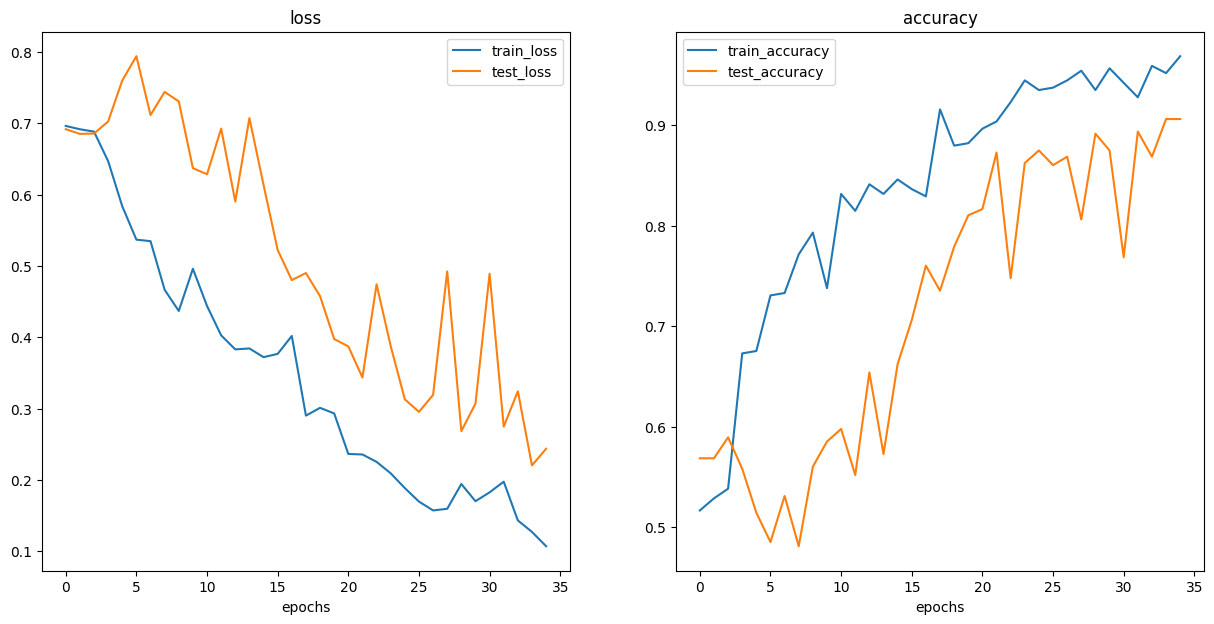

In [89]:
plot_loss_curves(model_0_results)

In [90]:
test_dir

PosixPath('Data/Dataset/Test')

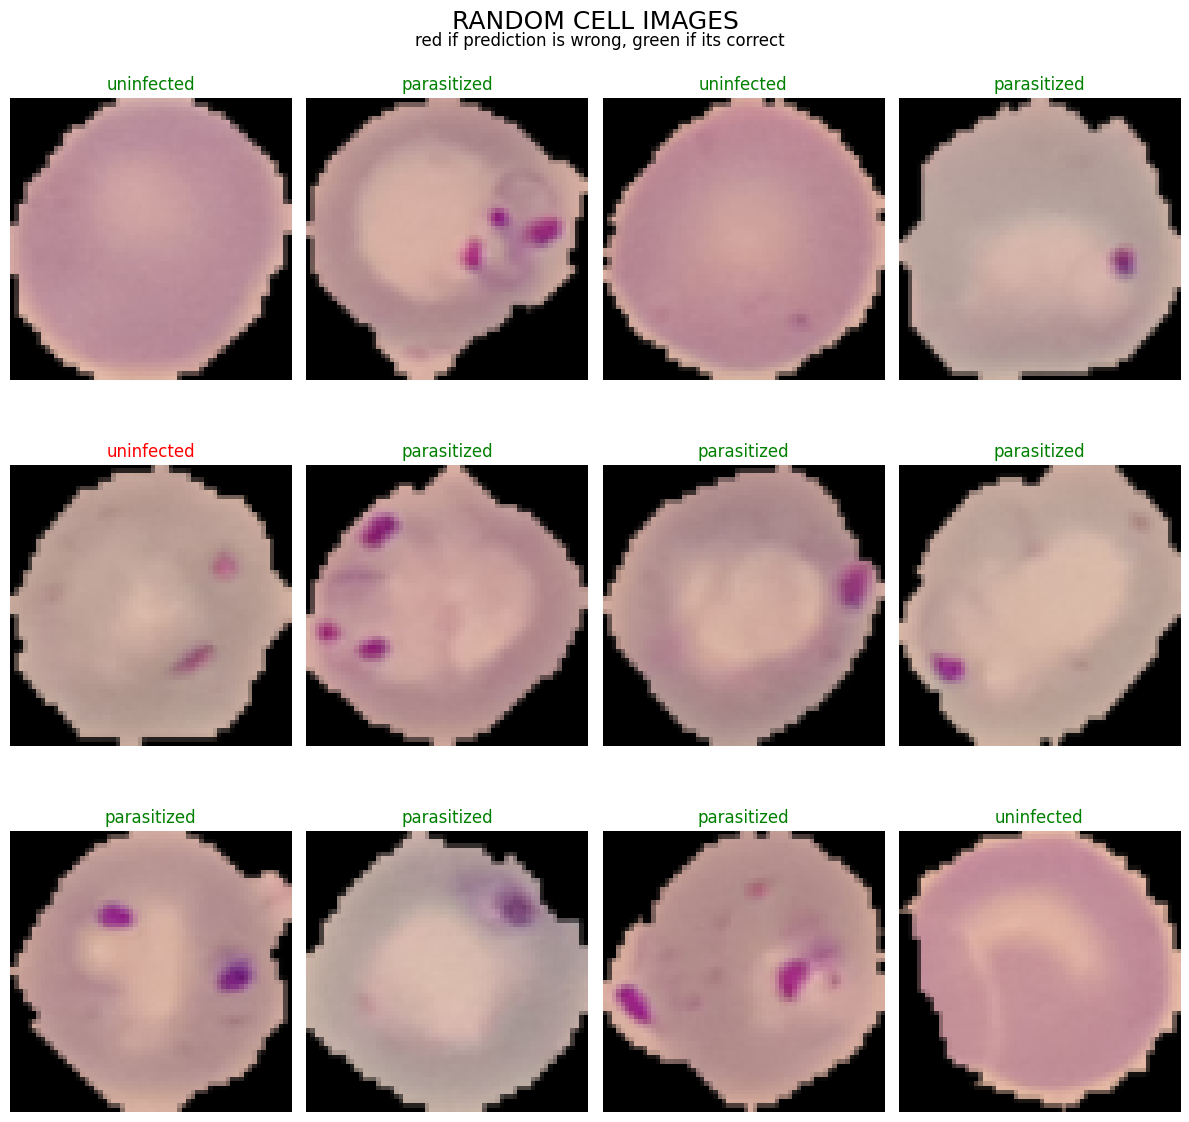

In [112]:
import random
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder


# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust size according to your model input
    transforms.ToTensor()
])

# Load test dataset
test_dataset = ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Randomly select 12 test images
random_indices = random.sample(range(len(test_dataset)), 12)
subset = Subset(test_dataset, random_indices)

# Load the subset
subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

# Assuming 'model' is your trained model
model_0.eval()

fig, axes = plt.subplots(3, 4, figsize=(12, 12))
axes = axes.flatten()

for i, (img, label) in enumerate(subset_loader):
    img = img.to(device)  # Use 'cuda' if you have a GPU
    label = label.to(device)

    # Get prediction
    with torch.no_grad():
        output = model_0(img)
    _, predicted = torch.max(output, 1)

    # Move data back to CPU for plotting
    img = img.cpu().squeeze().permute(1, 2, 0).numpy()
    label = label.cpu().item()
    predicted = predicted.cpu().item()

    true_class = 'Parasitized' if label == 0 else 'uninfected'
    predicted_class = 'parasitized' if predicted == 0 else 'uninfected'

    if label == predicted:
        title_color = 'green'
    else:
        title_color = 'red'

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(predicted_class, color=title_color)

fig.suptitle('RANDOM CELL IMAGES', fontsize=18)
plt.figtext(0.35, 0.95, 'red if prediction is wrong, green if its correct', fontsize=12)
plt.tight_layout()
plt.show()


An AI system like this reduces the time spent on diagnosis and can be life-saving in certain situations.

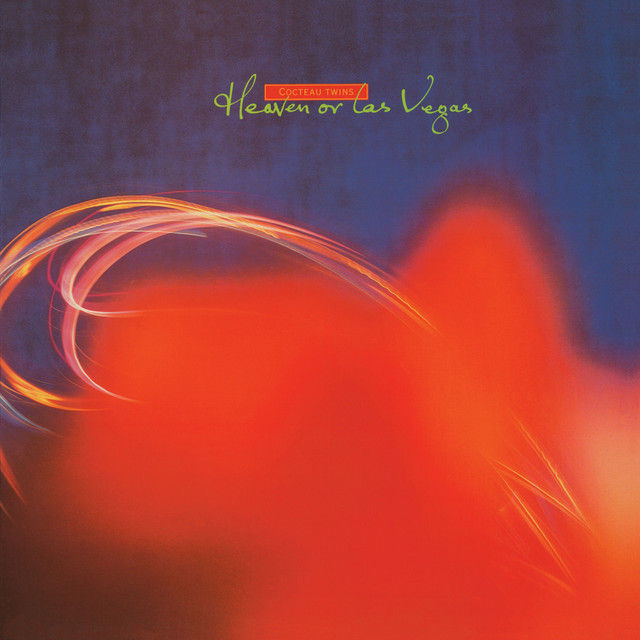